In [1]:
from sympy import *
from sympy.physics.mechanics import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

init_vprinting()

In [2]:
m1, m2, m3, l1, l2, g, t, u1, u2, lambda1, lambda2 = symbols('m1 m2 m3 l1 l2 g t u1 u2 lambda1 lambda2')
q1x, q1y, q2x, q2y, q3x, q3y = dynamicsymbols('q1x q1y q2x q2y q3x q3y')

M = Matrix([[m1, 0, 0], [0, m2, 0], [0, 0, m3]])
G = Matrix([[0, g], [0, g], [0, g]])
D_of_G = Matrix([[1, 0], [-1, 1], [0, -1]])

r1 = Matrix([[q1x], [q1y]])
r2 = Matrix([[q2x], [q2y]])
r3 = Matrix([[q3x], [q3y]])
Q = Matrix([[r1.T], [r2.T], [r3.T]])

r1e = r1 - r2
r2e = r2 - r3
Qe = Matrix([[r1e.T], [r2e.T]])

q1x_dot = diff(q1x, t)
q1y_dot = diff(q1y, t)
q2x_dot = diff(q2x, t)
q2y_dot = diff(q2y, t)
q3x_dot = diff(q3x, t)
q3y_dot = diff(q3y, t)

r1_dot = Matrix([[q1x_dot], [q1y_dot]])
r2_dot = Matrix([[q2x_dot], [q2y_dot]])
r3_dot = Matrix([[q3x_dot], [q3y_dot]])

r1e_dot = r1_dot - r2_dot
r2e_dot = r2_dot - r3_dot
Qe_dot = Matrix([[r1e_dot.T], [r2e_dot.T]])

R90 = Matrix([[0, -1], [1, 0]])

f1 = u1/l1*R90*r1e
f2 = Matrix([[0], [0]])
f3 = u2/l2*R90*r2e
F = Matrix([[f1.T], [f2.T], [f3.T]])

In [3]:
lambda_ = Matrix([[(1/m1+1/m2)*l1**2, -1/m2*r1e.dot(r2e)], [-1/m2*r1e.dot(r2e), (1/m2+1/m3)*l2**2]]).inv() * Matrix([[r1e.dot(f1/m1-f2/m2)+r1e_dot.dot(r1e_dot)], [r2e.dot(f2/m2-f3/m3)+r2e_dot.dot(r2e_dot)]])

In [4]:
Lambda = diag(*lambda_)
Gamma = D_of_G*Lambda*D_of_G.T*Q
Q_ddot = M.inv()*F - G - M.inv()*Gamma

q1x_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g), Q_ddot[0, 0])
q1y_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g), Q_ddot[0, 1])
q2x_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g), Q_ddot[1, 0])
q2y_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g), Q_ddot[1, 1])
q3x_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g), Q_ddot[2, 0])
q3y_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g), Q_ddot[2, 1])

K1 = 2
K2 = 2
Qed = Matrix([[0, l1], [l2, 0]])
f_edge = -K1*(Qe-Qed) - K2*Qe_dot + D_of_G.T*M.inv()*Gamma

# Projections
a = R90*r1e/(m1*l1)
b = f_edge[0, :].T
u1_temp = a.dot(b)*m1**2

a = -R90*r2e/(m3*l2)
b = f_edge[1, :].T
u2_temp = a.dot(b)*m3**2

u1_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g), u1_temp)
u2_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g), u2_temp)

In [5]:
Matrix([(R90*r1e/(m1*l1)).T, (-R90*r2e/(m3*l2)).T]).inv()

⎡                  l₁⋅m₁⋅q2x - l₁⋅m₁⋅q3x                                      
⎢─────────────────────────────────────────────────────────   ─────────────────
⎢q1x⋅q2y - q1x⋅q3y - q1y⋅q2x + q1y⋅q3x + q2x⋅q3y - q2y⋅q3x   q1x⋅q2y - q1x⋅q3y
⎢                                                                             
⎢                  -l₁⋅m₁⋅q2y + l₁⋅m₁⋅q3y                                     
⎢──────────────────────────────────────────────────────────  ─────────────────
⎣-q1x⋅q2y + q1x⋅q3y + q1y⋅q2x - q1y⋅q3x - q2x⋅q3y + q2y⋅q3x  -q1x⋅q2y + q1x⋅q3

 l₂⋅m₃⋅q1x - l₂⋅m₃⋅q2x                   ⎤
──────────────────────────────────────── ⎥
 - q1y⋅q2x + q1y⋅q3x + q2x⋅q3y - q2y⋅q3x ⎥
                                         ⎥
 -l₂⋅m₃⋅q1y + l₂⋅m₃⋅q2y                  ⎥
─────────────────────────────────────────⎥
y + q1y⋅q2x - q1y⋅q3x - q2x⋅q3y + q2y⋅q3x⎦

In [6]:
m1 = 1
m2 = 2
m3 = 3
l1 = 1
l2 = 1.5
g = 9.81

dt = 0.001
tf = 10
t = np.arange(0, tf, dt)

q1x_0 = 0
q1y_0 = 0
q2x_0 = l1/sqrt(2)
q2y_0 = -l1/sqrt(2)
q3x_0 = q2x_0
q3y_0 = q2y_0-l2
q1x_dot_0 = 0
q1y_dot_0 = 0
q2x_dot_0 = 0
q2y_dot_0 = 0
q3x_dot_0 = 10
q3y_dot_0 = 0

def ODE(t, y):
    q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot = y
    u1 = u1_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g)
    u2 = u2_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g)
    q1x_ddot = q1x_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g)
    q1y_ddot = q1y_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g)
    q2x_ddot = q2x_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g)
    q2y_ddot = q2y_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g)
    q3x_ddot = q3x_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g)
    q3y_ddot = q3y_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, u1, u2, m1, m2, m3, l1, l2, g)
    return (q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, q1x_ddot, q1y_ddot, q2x_ddot, q2y_ddot, q3x_ddot, q3y_ddot)

sol = solve_ivp(ODE, (0, tf), (q1x_0, q1y_0, q2x_0, q2y_0, q3x_0, q3y_0, q1x_dot_0, q1y_dot_0, q2x_dot_0, q2y_dot_0, q3x_dot_0, q3y_dot_0), t_eval=t, method="DOP853", rtol=1e-10, atol=1e-10)
q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot = sol.y

u1 = np.vectorize(u1_expr)(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g)
u2 = np.vectorize(u2_expr)(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g)

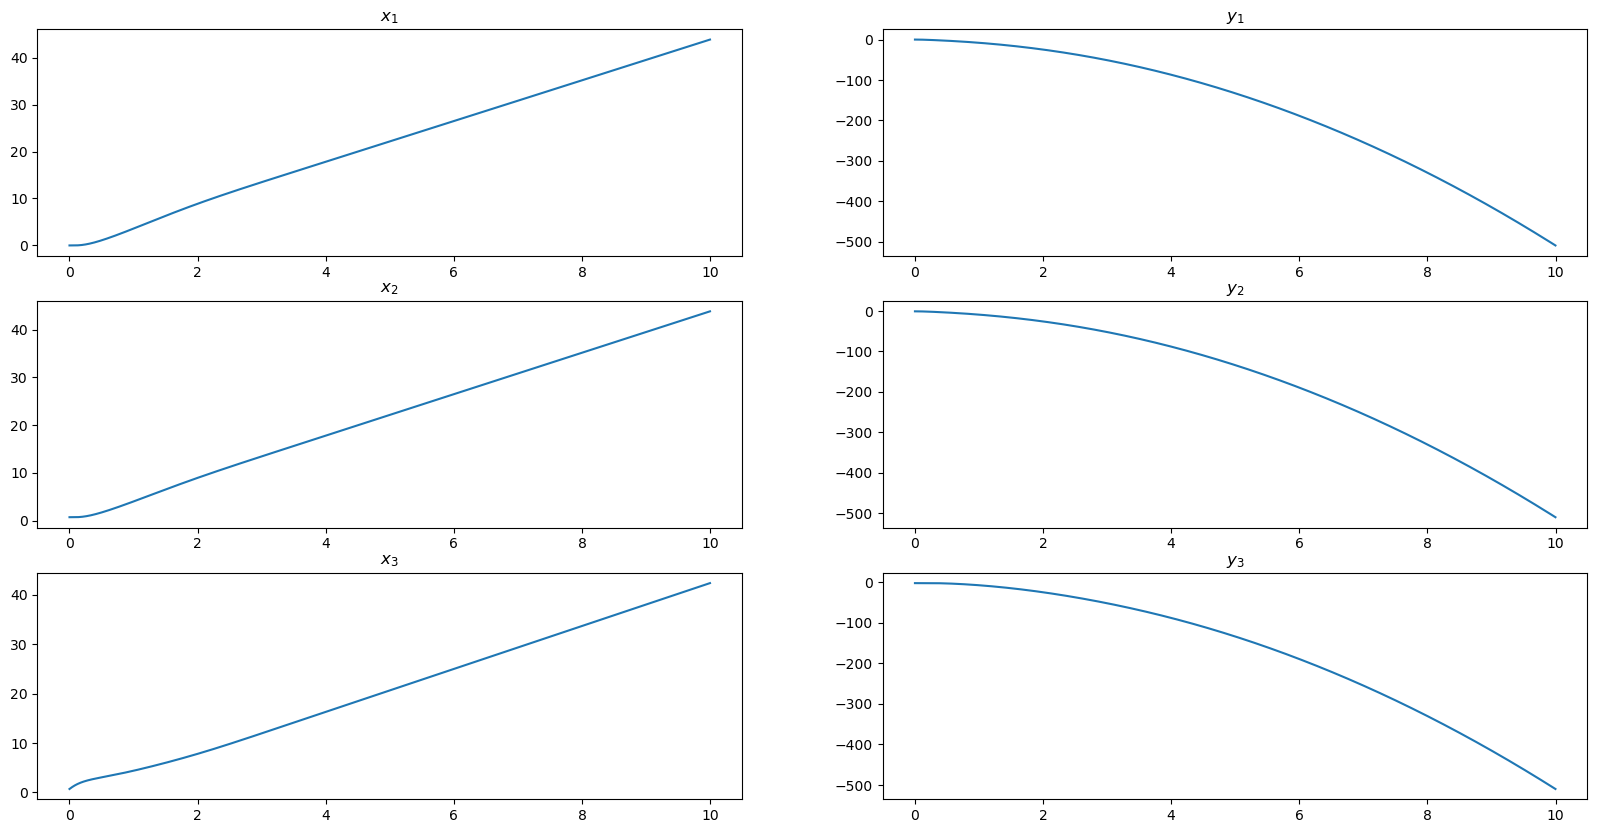

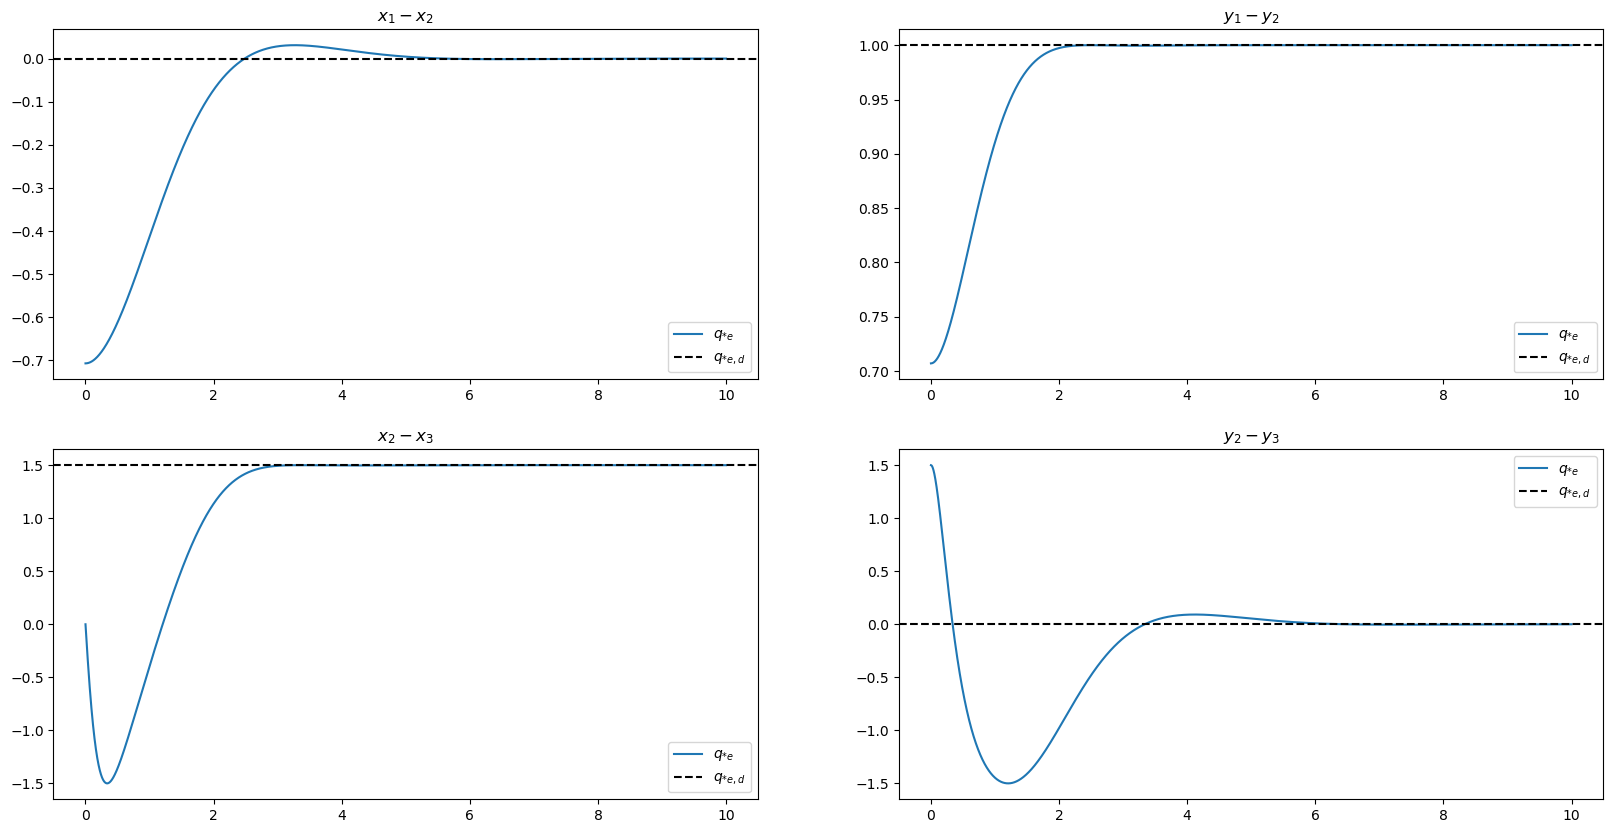

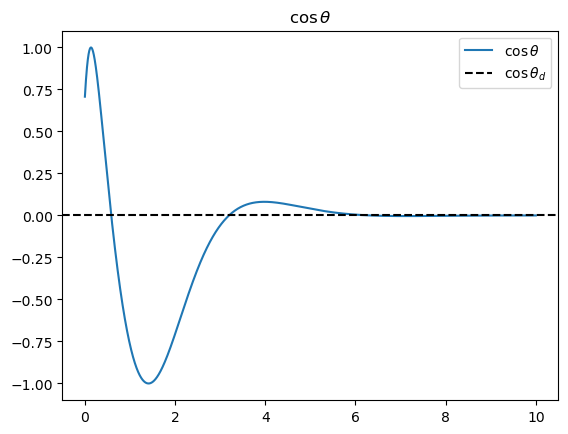

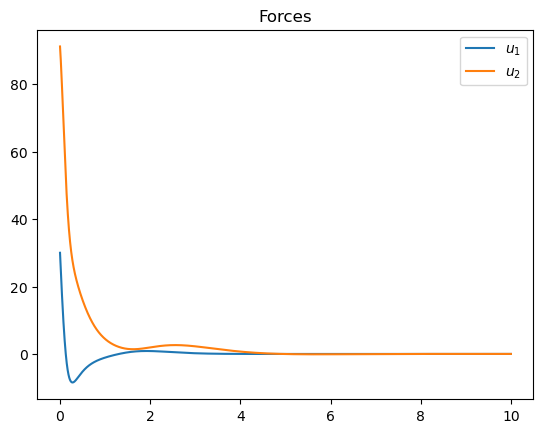

In [7]:
# Nodes
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
plt.plot(t, q1x, label='q1x')
plt.title('$x_1$')

plt.subplot(3, 2, 2)
plt.plot(t, q1y, label='q1y')
plt.title('$y_1$')

plt.subplot(3, 2, 3)
plt.plot(t, q2x, label='q2x')
plt.title('$x_2$')

plt.subplot(3, 2, 4)
plt.plot(t, q2y, label='q2y')
plt.title('$y_2$')

plt.subplot(3, 2, 5)
plt.plot(t, q3x, label='q3x')
plt.title('$x_3$')

plt.subplot(3, 2, 6)
plt.plot(t, q3y, label='q3y')
plt.title('$y_3$')

# Edges
Qed_val = Qed.subs({'l1': l1, 'l2': l2})

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(t, q1x-q2x, label='$q_{*e}$')
plt.axhline(Qed_val[0, 0], color='black', linestyle='--', label='$q_{*e,d}$')
plt.title('$x_1-x_2$')
plt.legend()
#plt.gca().set_ylim(-0.25, 1.25)

plt.subplot(2, 2, 2)
plt.plot(t, q1y-q2y, label='$q_{*e}$')
plt.axhline(Qed_val[0, 1], color='black', linestyle='--', label='$q_{*e,d}$')
plt.title('$y_1-y_2$')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t, q2x-q3x, label='$q_{*e}$')
plt.axhline(Qed_val[1, 0], color='black', linestyle='--', label='$q_{*e,d}$')
plt.title('$x_2-x_3$')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(t, q2y-q3y, label='$q_{*e}$')
plt.axhline(Qed_val[1, 1], color='black', linestyle='--', label='$q_{*e,d}$')
plt.title('$y_2-y_3$')
plt.legend()

# Theta
plt.figure()
plt.plot(t, ((q1x-q2x)*(q2x-q3x)+(q1y-q2y)*(q2y-q3y))/(l1*l2), label=r'$\cos\theta$')
plt.axhline(Qed_val[0, :].dot(Qed_val[1, :])/(l1*l2), color='black', linestyle='--', label=r'$\cos\theta_{d}$')
plt.title(r'$\cos\theta$')
plt.legend()
#plt.gca().set_ylim(-1.01, -0.99)

# Forces
plt.figure()
plt.plot(t, u1, label='$u_1$')
plt.plot(t, u2, label='$u_2$')
plt.title('Forces')
plt.legend()